## Neural Networks

Neural networks can be constructed using the `torch.nn` package.

Now that you had a glimpse of `autograd`, `nn` depends on `autograd` to define models and differentiate them. An `nn.Module` contains layers, and a method `forward(input)` that returns the `output`

### Define the network

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # 1. input image channel, 6 output channels, 5x5 square covolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


You just have to define the `forward` function, and the `backward` function (where gradients are computed) is automatically defined for you using `autograd`. You can use any of the Tensor operations in the `forward` function.

The learnable parameters of a model are returned by `net.parameters()`

In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's weight

10
torch.Size([6, 1, 5, 5])


The input to the forward is an `autograd.Variable`, and so is the output. 

Note: Excepted input size to the `Net` is 32x32. To use it on MNIST dataset, please resize the images from the dataset to 32x32

In [5]:
input = Variable(torch.randn(1,1,32,32))
out = net(input)
print(out)

Variable containing:
 0.1808 -0.0616  0.0856  0.0122  0.0199  0.1032  0.0190  0.0364  0.1002  0.1310
[torch.FloatTensor of size 1x10]



Zero the gardient buffers of all parameters and backprops with random gradients:

In [6]:
net.zero_grad()
out.backward(torch.randn(1, 10))

To add a fake batch dimension for Tensor(channel x Height x Width)

use function `input.unsqueeze(0)`

### Loss Function

In [7]:
output = net(input)
target = Variable(torch.arange(1, 11)) # a dummy target
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

Variable containing:
 37.7647
[torch.FloatTensor of size 1]



In [11]:
loss.data[0]

37.76470184326172

In [12]:
print(loss.grad_fn) #MSEloss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLU

### Backprop

In [13]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
-0.1001
-0.0977
-0.1053
 0.0387
 0.0374
-0.0215
[torch.FloatTensor of size 6]



In [24]:
print(net.conv1.weight.grad)

Variable containing:
(0 ,0 ,.,.) = 
  0.1363 -0.0974 -0.0647  0.0618  0.0730
  0.0599  0.0178 -0.0253  0.0371 -0.0621
 -0.1536 -0.1319 -0.0562  0.1421 -0.0734
 -0.0084  0.1390 -0.0127  0.0704 -0.0056
  0.1197  0.0091 -0.0245 -0.0532 -0.0935

(1 ,0 ,.,.) = 
  0.0255  0.0844  0.0364 -0.0797  0.0694
  0.0410 -0.0016  0.1918 -0.1448  0.0756
 -0.0449  0.0276 -0.0316 -0.1496 -0.0213
 -0.0591 -0.1426  0.0320 -0.0288 -0.0779
  0.0451  0.2268 -0.0004  0.0973 -0.0108

(2 ,0 ,.,.) = 
 -0.0817  0.0807 -0.0320  0.0341 -0.0825
  0.1600 -0.0746 -0.2204 -0.2070 -0.0467
  0.1135  0.0470 -0.0718  0.0427  0.0360
 -0.0360  0.1095 -0.0045  0.0666 -0.0755
 -0.0058 -0.0492 -0.0242  0.1519  0.0364

(3 ,0 ,.,.) = 
 -0.1619  0.0418  0.1302  0.0701 -0.0239
 -0.0588  0.1508  0.0187  0.0699 -0.0009
 -0.1621 -0.1019 -0.0306  0.1969  0.0177
 -0.0886  0.1183  0.0247 -0.0169 -0.0342
  0.0436  0.0551  0.0144 -0.1106  0.0419

(4 ,0 ,.,.) = 
 -0.1109 -0.1734  0.0291 -0.0148 -0.0647
  0.0605  0.0620 -0.0135 -0.0656  0.075

In [25]:
net.state_dict().keys()


odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

### Update the weights

```
 weight = weight - learning_rate * gradient
```

In [26]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [27]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()   # does the update

## Training a classifier

We will do the following steps in order:
  1. load and normalizing the CIFAR10 training and test dataset using `torchvison`
  1. Define a Convolution Netural Network
  1. Define a loss function
  1. Train the network on the training data
  1. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms

In [40]:
torch.cuda.set_device(0)

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


  dog  frog  deer   car


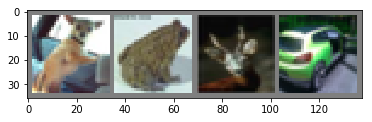

In [41]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### 2. Define a Convolution Neural Network

In [37]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()

### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum

In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [42]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0   

print("Finished Training")

[1,  2000] loss: 1.351
[1,  4000] loss: 1.309
[1,  6000] loss: 1.324
[1,  8000] loss: 1.328
[1, 10000] loss: 1.297
[1, 12000] loss: 1.255
[2,  2000] loss: 1.210
[2,  4000] loss: 1.182
[2,  6000] loss: 1.195
[2,  8000] loss: 1.175
[2, 10000] loss: 1.173
[2, 12000] loss: 1.173
Finished Training


### 5. Test the network on the test data

GroundTruth:    cat  ship  ship plane


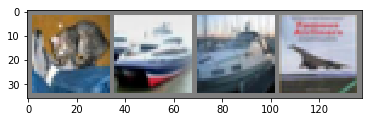

In [43]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [44]:
outputs = net(Variable(images))

In [45]:
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


Let us look at how the network performs on the whole dataset.

In [46]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [49]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
        
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i])) 

Accuracy of plane : 59 %
Accuracy of   car : 40 %
Accuracy of  bird : 49 %
Accuracy of   cat : 24 %
Accuracy of  deer : 45 %
Accuracy of   dog : 60 %
Accuracy of  frog : 59 %
Accuracy of horse : 61 %
Accuracy of  ship : 82 %
Accuracy of truck : 65 %


## Training on GPU

In [50]:
net.cuda()

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [51]:
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

RuntimeError: Variable data has to be a tensor, but got Variable